In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
import json
import torch
import gc
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from spacy import displacy
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-22 10:37:03.162214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747910223.191836     780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747910223.200532     780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/allergy/project-5-at-2025-05-15-16-41-cf11f6bb.json
/kaggle/input/allergy/dataset.csv


In [5]:
allergy = pd.read_csv('/kaggle/input/allergy/dataset.csv', sep=';', encoding='utf-8')

In [6]:
allergy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4143 non-null   int64 
 1   text        4143 non-null   object
dtypes: int64(1), object(1)
memory usage: 64.9+ KB


In [7]:
allergy.head(15) # Посмотрим первые 15 строк

,Unnamed: 0,text
0,0,Утром проснулась с отекшими глазами)))
1,1,"Открывала окна без спандбонда, нормально, ниче..."
2,2,"Пока изменений в худшую сторону нет. Каникулы,..."
3,3,Я сегодня еле разодрала глаза и до сих сдуться...
4,4,"Я тоже сегодня опухшая, надутая, глаза дерет, ..."
5,5,"А интересно, ловушка завтра совсем нулевая буд..."
6,6,Ребенок сегодня проснулся с отекшими глазами (...
7,7,"Вышла на улицу, Одинцово мо, тяжело дышать на ..."
8,8,"Второй день нормально. Сегодня даже легче,чем ..."
9,9,"Вчера после прогулки глаза отекли , чесались ...."


In [8]:
data_l = allergy[:185] # Возьмем первые 185 строк

In [9]:
upload_tasks = []

for _, rec in data_l.iterrows():
    upload_tasks.append({"text": rec.text, "id": rec['Unnamed: 0']})

In [10]:
# Пример для проверки на первых 15 строках
for task in upload_tasks[:15]:
    print(task)

{'text': 'Утром проснулась с отекшими глазами)))', 'id': 0}
{'text': 'Открывала окна без спандбонда, нормально, ничего не почувствовала, кроме холода)\nА гулять совсем неохота в такую погоду))', 'id': 1}
{'text': 'Пока изменений в худшую сторону нет. Каникулы, с такой погодой долго не погуляем. Конечно хотелось бы старта березы и потом такую погоду, но живём с тем что имеем. Вчера достала очки для плавания, под шапку, кепку , смотрится не странно. Ребёнок с миопией ещё, очки на алиекспрессе брала с диоптриями. Южное бутово, Москва. Ребёнок на базе.', 'id': 2}
{'text': 'Я сегодня еле разодрала глаза и до сих сдуться не могу... Воспаление , текут глаза, нос изодрала, чихи, слезы, тяжесть. Погода не помогает .', 'id': 3}
{'text': 'Я тоже сегодня опухшая, надутая, глаза дерет, чихи, сухота кожи и горла, глаза текут, даже опатенол не берет, никсар не хочет сегодня работать. Чувствую отвратно себя. Тяжело, грузно', 'id': 4}
{'text': 'А интересно, ловушка завтра совсем нулевая будет? Или нале

**Работаю в kaggle, размечу локально и после загружу json**

In [11]:
# Функция парсит JSON-файл с разметкой сущностей и преобразует его в список словарей
def parse_json(file_path):
    """Преобразует JSON-файл в список текстов и сущностей"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)  # Загружаем весь JSON
    
    records = [] # Создаем список
    for item in data:
        text = item['data']['text']
        entities = []
        
        # Извлекаем все сущности
        for annotation in item['annotations'][0]['result']:
            if annotation['type'] == 'labels':  # Пропускаем связи между сущностями
                value = annotation['value']
                entities.append({
                    'start': value['start'], # Начальная позиция
                    'end': value['end'], # Конечная позиция
                    'label': value['labels'][0] # Тип сущности (например, symptom, region)
                })
        
        records.append({'text': text, 'entities': entities})
    
    return records

Функция преобразует текст и его сущности из JSON-файла в формат BIO (B-начало сущности, I-продолжение, O-не сущность), затем токенизирует текст и выравнивает метки с токенами, используя offset_mapping

In [12]:
def create_bio_labels(text, entities, tokenizer):
    """Преобразует текст и сущности в формат BIO (B-метка, I-метка, O)"""
    # Инициализируем список меток равный длине текста
    labels = ['O'] * len(text)
    
    # Отмечаем позиции сущностей
    for entity in entities:
        start = entity['start']
        end = entity['end']
        label = entity['label']
        
        # Помечаем начало и продолжение сущности
        if start < len(labels):
            labels[start] = f'B-{label}'
            for i in range(start+1, end):
                if i < len(labels):
                    labels[i] = f'I-{label}'
    
    # Токенизируем текст
    tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding='max_length', max_length=128)
    tokens = tokenizer.convert_ids_to_tokens(tokenized['input_ids'])
    offset_mapping = tokenized['offset_mapping']
    
    # Выравниваем метки с токенами
    aligned_labels = []
    for token_start, token_end in offset_mapping:
        # Если токен внутри сущности - берем соответствующую метку
        if token_start < len(labels):
            aligned_labels.append(labels[token_start])
        else:
            aligned_labels.append('O')
    
    return tokenized, aligned_labels

In [13]:
# Функция подготавливает данные для обучения модели NER
def prepare_dataset(data, tokenizer, label2id):
    """Преобразует данные в формат, подходящий для обучения"""
    encoded_inputs = [] # токенизированные вхожные последовательности
    encoded_labels = [] # списки меток в числовом формате для каждого текста
    
    for item in data:
        # Получаем BIO-метки
        tokenized, labels = create_bio_labels(
            item['text'], 
            item['entities'], 
            tokenizer
        )
        
        # Преобразуем метки в ID
        label_ids = [label2id[label] for label in labels]
        
        encoded_inputs.append(tokenized)
        encoded_labels.append(label_ids)
    
    return encoded_inputs, encoded_labels

In [14]:
# Класс преобразует токенизированные входы (encodings) и метки (labels) в формат, который может обрабатывать модель
class NERDataset(Dataset):
    # encodings : Токенизированные входы (например, input_ids, attention_mask, offset_mapping)
    # labels : Метки в формате BIO (например, B-symptom, I-symptom, O), преобразованные в числовые ID
    # self.encodings и self.labels : Сохраняются как атрибуты класса для последующего доступа
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # Возвращает количество записей в датасете
    def __len__(self):
        return len(self.labels)
        
    # Преобразование в тензоры :
    # Каждое поле (input_ids, attention_mask, ...) преобразуется в torch.Tensor.
    # Метки (labels) : Преобразуются в тензор и добавляются в словарь item.
    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [15]:
# JSON из Label Studio
file_path = "/kaggle/input/allergy/project-5-at-2025-05-15-16-41-cf11f6bb.json"

In [16]:
# Загрузка данных
print("1. Загрузка данных...")
raw_data = parse_json(file_path)
print(f"Найдено записей: {len(raw_data)}")

1. Загрузка данных...
Найдено записей: 143


In [17]:
# Сбор статистики
all_labels = []
for record in raw_data:
    for entity in record["entities"]:
        all_labels.append(entity["label"])

label_counts = Counter(all_labels)

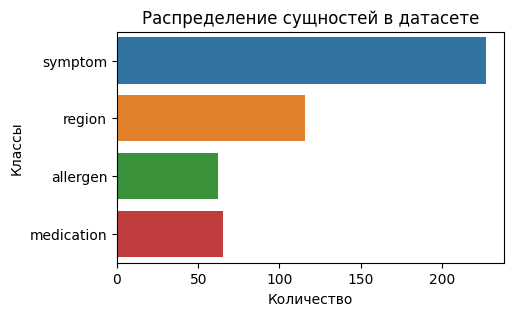

In [18]:
# Визуализация
plt.figure(figsize=(5, 3))
sns.barplot(x=list(label_counts.values()), y=list(label_counts.keys()))
plt.title("Распределение сущностей в датасете")
plt.xlabel("Количество")
plt.ylabel("Классы")
plt.show()

In [19]:
# Создание словаря меток
print("\n2. Создание словаря меток...")
unique_labels = set()
for item in raw_data:
    for entity in item['entities']:
        unique_labels.add(entity['label'])

# Генерируем все возможные метки в формате BIO
bio_labels = ["O"]
for label in sorted(unique_labels):
    bio_labels.append(f"B-{label}")
    bio_labels.append(f"I-{label}")

# Создаем словари
label2id = {label: i for i, label in enumerate(bio_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Доступные метки:", bio_labels)
print("label2id:", label2id)


2. Создание словаря меток...
Доступные метки: ['O', 'B-allergen', 'I-allergen', 'B-medication', 'I-medication', 'B-region', 'I-region', 'B-symptom', 'I-symptom']
label2id: {'O': 0, 'B-allergen': 1, 'I-allergen': 2, 'B-medication': 3, 'I-medication': 4, 'B-region': 5, 'I-region': 6, 'B-symptom': 7, 'I-symptom': 8}


In [20]:
# Загрузка токенизатора
print("\n3. Загрузка токенизатора...")
tokenizer = BertTokenizerFast.from_pretrained("DeepPavlov/rubert-base-cased")


3. Загрузка токенизатора...


In [21]:
# Подготовка датасета
print("\n4. Подготовка датасета...")
inputs, labels_list = prepare_dataset(raw_data, tokenizer, label2id)


4. Подготовка датасета...


In [22]:
# Разделение на train и temp (40% для val + test)
print("\n5. Разделение на train/val/test...")
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(
    inputs, labels_list, test_size=0.4, random_state=42
)


5. Разделение на train/val/test...


In [23]:
# Разделение temp на val и test (по 20% от общего датасета)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    temp_inputs, temp_labels, test_size=0.5, random_state=42
)

In [24]:
# Создание датасетов
print("\n6. Создание датасетов...")
train_dataset = NERDataset(train_inputs, train_labels)
val_dataset = NERDataset(val_inputs, val_labels)
test_dataset = NERDataset(test_inputs, test_labels)


6. Создание датасетов...


In [25]:
print("Длины датасетов")
print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

Длины датасетов
Train: 85
Val: 29
Test: 29


In [26]:
 # Загрузка модели
print("\n6. Загрузка модели...")
model = AutoModelForTokenClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased", # предобученная модель RuBERT
    num_labels=len(bio_labels), # количество меток (включая O, B-..., I-...)
    id2label=id2label, # словари для преобразования меток в числа и обратно
    label2id=label2id
)


6. Загрузка модели...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Обучение модели
print("\n7. Обучение модели...")
training_args = TrainingArguments(
    output_dir="ner_model",
    eval_strategy="epoch", # валидацияпосле каждой эпохи
    learning_rate=5e-5, # стандартная для BERT/RuBERT и подходит для NER
    per_device_train_batch_size=8, # размер батча для обучения
    per_device_eval_batch_size=8, # размер батча для валидации
    num_train_epochs=5, # количество эпох обучения
    weight_decay=0.01, # регуляризация для предотвращения переобучения
    save_strategy="epoch", # сохраняем модель после каждой эпохи
    load_best_model_at_end=True, # загружаем лучшую модель в конце обучения
    metric_for_best_model="f1",  # F1-метрика для выбора лучшей модели
    report_to="none"
)


7. Обучение модели...


Объединим батчи в тензоры и сохраним соответствия между токенами и метками

In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2) # преобразует логиты модели в метки, выбирает метку с максимальным значением для каждого токена

    # преобразование ID в текстовые метки
    true_predictions = [
        [bio_labels[p] for (p, l) in zip(prediction, label) if l != -100] # пропускает padding-токены
        for prediction, label in zip(predictions, labels)
    ]

    # преобразование истинных ID в метки
    true_labels = [
        [bio_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return {
        "f1": f1_score(true_labels, true_predictions, average="macro"), # метрика оценки f1_macro
    }

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [31]:
# Удалим старые чекпоинты
if os.path.exists("ner_model"):
    shutil.rmtree("ner_model")

# Посмотрим, что папка существует
os.makedirs("ner_model", exist_ok=True)

In [32]:
# Функция очистки памяти после каждой эпохи обучения, чтобы избежать переполнения памяти в Kaggle
def clear_memory():
    torch.cuda.empty_cache()  # очистка кэша GPU
    gc.collect()  # сборщик мусора Python

In [33]:
# Цикл обучения с очисткой памяти
for epoch in range(8):
    trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.096411,0.189288
2,No log,0.891733,0.207682
3,No log,0.888589,0.214556
4,No log,0.825040,0.217672
5,No log,0.766070,0.217471


Epoch,Training Loss,Validation Loss,F1
1,No log,0.564479,0.515661
2,No log,0.456149,0.614384
3,No log,0.448442,0.844868
4,No log,0.400880,0.824907
5,No log,0.392088,0.854838


Epoch,Training Loss,Validation Loss,F1
1,No log,0.392378,0.899501
2,No log,0.361209,0.944664
3,No log,0.360729,0.921451
4,No log,0.344014,0.940164
5,No log,0.347360,0.944453


Epoch,Training Loss,Validation Loss,F1
1,No log,0.328657,0.943161
2,No log,0.339639,0.948979
3,No log,0.355925,0.948653
4,No log,0.365260,0.952584
5,No log,0.365962,0.950111


Epoch,Training Loss,Validation Loss,F1
1,No log,0.355376,0.950306
2,No log,0.346977,0.951027
3,No log,0.349299,0.946155
4,No log,0.353036,0.945705
5,No log,0.354174,0.948221


Epoch,Training Loss,Validation Loss,F1
1,No log,0.340440,0.947144
2,No log,0.349897,0.948735
3,No log,0.360647,0.951023
4,No log,0.362093,0.952790
5,No log,0.360928,0.948849


Epoch,Training Loss,Validation Loss,F1
1,No log,0.372969,0.946127
2,No log,0.382457,0.953490
3,No log,0.386886,0.949616
4,No log,0.385521,0.949605
5,No log,0.384944,0.947998


Epoch,Training Loss,Validation Loss,F1
1,No log,0.372795,0.952840
2,No log,0.374604,0.954022
3,No log,0.371607,0.954022
4,No log,0.367970,0.953301
5,No log,0.367862,0.953301


In [34]:
# Оценка модели
print("\n8. Оценка модели...")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=2)


8. Оценка модели...


In [35]:
# Преобразуем предсказания в читаемый формат
true_predictions = [
    [id2label[p] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, predictions.label_ids)
]
    
true_labels = [
    [id2label[l] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, predictions.label_ids)
]

In [36]:
# Преобразование в читаемый формат
true_labels_flat = [item for sublist in true_labels for item in sublist]
preds_flat = [item for sublist in true_predictions for item in sublist]


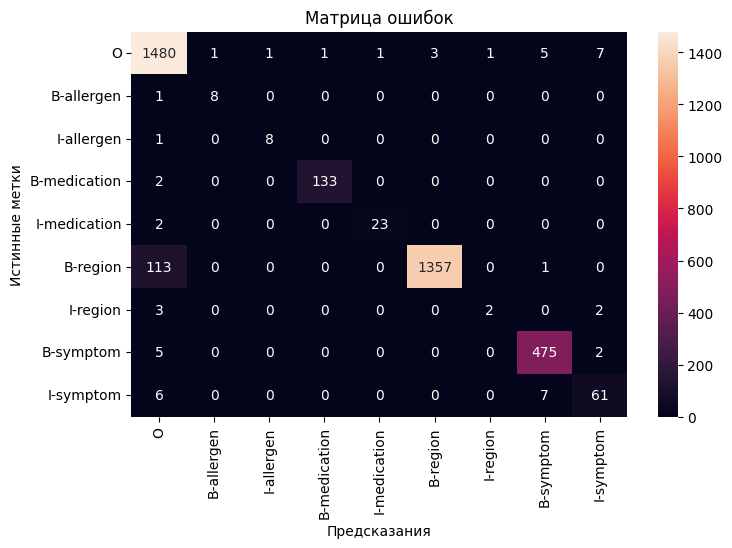

In [37]:
# Построение матрицы ошибок
cm = confusion_matrix(true_labels_flat, preds_flat, labels=bio_labels)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=bio_labels, yticklabels=bio_labels)
plt.title("Матрица ошибок")
plt.xlabel("Предсказания")
plt.ylabel("Истинные метки")
plt.show()

In [38]:
# Вывод отчета
print("\nClassification Report:")
print(classification_report(true_labels, true_predictions))


Classification Report:
              precision    recall  f1-score   support

    allergen       0.89      0.89      0.89         9
  medication       0.98      0.98      0.98       135
      region       1.00      0.92      0.96      1471
     symptom       0.94      0.96      0.95       482

   micro avg       0.98      0.94      0.96      2097
   macro avg       0.95      0.94      0.94      2097
weighted avg       0.98      0.94      0.96      2097



**Модель DeepPavlov/rubert-base-cased — это предобученная версия BERT на русском языке , которая подходит для задач NER. Модель учитывает дисбаланс классов и показывает хорошие результаты, стабильно находит симптомы и лекарства, все регионы находятся , даже редкие. F1-score выше 0.95 → Модель хорошо сбалансирована между точностью и полнотой.**